In [12]:
from random import sample

import warnings
import torch
from torch import device, cuda, autocast
from torch.cuda.amp import GradScaler
from torch.nn import BCEWithLogitsLoss
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm

import flyvision
import wandb
from conv_models import DecodingImagesCNN
from from_retina_to_connectome_utils import predictions_and_corrects_from_model_results, update_results_df, update_running_loss, initialize_results_df
from from_video_to_training_batched_funcs import get_files_from_directory, select_random_videos
from larvae.utils import plot_weber_fraction
from logs_to_wandb import log_running_stats_to_wandb, log_validation_stats_to_wandb
from layer_activation_data_processing import DataBatchProcessor, prepare_dataloader


warnings.filterwarnings(
    'ignore',
    message='invalid value encountered in cast',
    category=RuntimeWarning,
    module='wandb.sdk.data_types.image'
)
torch.manual_seed(1234)
dtype = torch.float

device_type = "cuda" if cuda.is_available() else "cpu"
DEVICE = device(device_type)

TRAINING_DATA_DIR = "images/easy_v2"
TESTING_DATA_DIR = "images/easy_images"
VALIDATION_DATA_DIR = "images/easyval_images"

debugging = False
debug_length = 20
wandb_ = True
wandb_images_every = 100
small = True
small_length = 2000

num_epochs = 1

test_every = 2 if small else 10
batch_size = 32 if small else 128

channel_sizes = [16, 32, 64]
mult_size = 1
channel_sizes = [int(a * mult_size) for a in channel_sizes]
dropout = .1
max_lr = 0.01
base_lr = 0.001
weight_decay = 0.0001

use_one_cycle_lr = False

model_config = {
    "debugging": debugging,
    "num_epochs": num_epochs,
    "batch_size": batch_size,
    "channel_sizes": channel_sizes,
    "dropout": dropout,
    "base_lr": base_lr,
    "max_lr": max_lr,
    "weight_decay": weight_decay
}

In [13]:
network_view = flyvision.NetworkView(flyvision.results_dir / "opticflow/000/0000")
network = network_view.init_network(chkpt="best_chkpt")
extent, kernel_size = 15, 13 # same as in the paper
receptors = flyvision.rendering.BoxEye(extent=extent, kernel_size=kernel_size)

training_videos = get_files_from_directory(TRAINING_DATA_DIR)
test_videos = get_files_from_directory(TESTING_DATA_DIR)
validation_videos = get_files_from_directory(TESTING_DATA_DIR)

if small:
    training_videos = sample(training_videos, small_length)
    test_videos = sample(test_videos, small_length)
    validation_videos = sample(validation_videos, int(small_length / 5))
    

if len(training_videos) == 0:
    print("I can't find any training images or videos!")

In [14]:
model = DecodingImagesCNN(
    out_channels_1 = channel_sizes[0],
    out_channels_2 = channel_sizes[1],
    out_channels_3 = channel_sizes[2],
    dropout = dropout
).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=base_lr, weight_decay=weight_decay)

# Initialize the scheduler
iterations = debug_length if debugging else len(training_videos) // batch_size
if use_one_cycle_lr:
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, total_steps=int(num_epochs * iterations / test_every), anneal_strategy='linear')

scaler = GradScaler()

# Initialize the loss function
criterion = BCEWithLogitsLoss()

In [15]:
if wandb_:
    # Start wandb run
    wandb.init(project='la_classification', config=model_config)

results = initialize_results_df()

# Training loop
for epoch in range(num_epochs):
    model.train()
    already_selected = []
    test_already_selected = []
    running_loss = 0.0
    total_correct = 0
    total = 0
    for i in tqdm(range(iterations)):
        
        batch_files, already_selected = select_random_videos(
                training_videos, batch_size, already_selected
        )
        bd_processor = DataBatchProcessor(batch_size, receptors, network, store_to_wandb=(wandb_ and i % wandb_images_every == 0))
        decoding_images, labels = bd_processor.preprocess_batch(batch_files)
        dataloader = prepare_dataloader(decoding_images, labels, dtype)
        
        for inputs, batch_labels in dataloader:
            inputs, batch_labels = inputs.to(DEVICE), batch_labels.to(DEVICE)
            optimizer.zero_grad()
    
            with autocast(device_type):
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), batch_labels)
                loss.backward()
                optimizer.step()
    
                # Calculate run parameters
                predictions, batch_labels_cpu, correct = predictions_and_corrects_from_model_results(outputs, batch_labels)
                results = update_results_df(results, bd_processor.batch_files, predictions, batch_labels_cpu, correct)
                running_loss += update_running_loss(loss, inputs)
                total += batch_labels.shape[0]
                total_correct += correct.sum()

        # Test phase
        # no need to test if we are not updating the learning rate
        if use_one_cycle_lr and (i + 1) % test_every == 0:
            model.eval()
            test_loss = 0.0
            test_correct = 0
            test_total = 0

            with torch.no_grad():
                batch_files, test_already_selected = select_random_videos(
                        test_videos, batch_size, test_already_selected
                )
                # in case we run out of test videos
                if len(test_videos) - len(test_already_selected) < batch_size:
                    test_already_selected = []
                bd_processor = DataBatchProcessor(batch_size, receptors, network)
                decoding_images, labels = bd_processor.preprocess_batch(batch_files)
                dataloader = prepare_dataloader(decoding_images, labels, dtype)
                
                for inputs, batch_labels in dataloader:
                    inputs, batch_labels = inputs.to(DEVICE), batch_labels.to(DEVICE)

                    outputs = model(inputs)
                    loss = criterion(outputs.squeeze(), batch_labels)

                    predictions, batch_labels_cpu, test_correct = predictions_and_corrects_from_model_results(outputs, batch_labels)
                    test_loss += update_running_loss(loss, inputs)
                    test_total += batch_labels_cpu.shape[0]

            test_loss /= test_total
            test_accuracy = test_correct.sum() / test_total

            # Step the scheduler with the test loss
            if use_one_cycle_lr:
                last_learning_rate = scheduler.get_last_lr()
                scheduler.step()
                new_learning_rate = scheduler.get_last_lr()
                if last_learning_rate != new_learning_rate:
                    print(f'Learning rate changed from {last_learning_rate} to {new_learning_rate}')
                    last_learning_rate = new_learning_rate

        # Log metrics to wandb
        if wandb_:
            log_running_stats_to_wandb(epoch, i, running_loss, total_correct, total, results)
            if use_one_cycle_lr:
                wandb.log({"learning_rate": scheduler.get_last_lr()})

    print(f'Epoch {epoch+1}, Training Loss: {running_loss / total}, Training Accuracy: {total_correct / total}')
    if use_one_cycle_lr:
        print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')
torch.cuda.empty_cache()

accuracy,▁▂▂▃▂▂▂▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██████
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
iteration,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▅▅▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▂▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
accuracy,0.62954
epoch,0
iteration,61
loss,0.64726


100%|██████████| 62/62 [29:01<00:00, 28.10s/it]

Epoch 1, Training Loss: 0.6382327906547054, Training Accuracy: 0.6355846774193549


In [16]:
model.eval() 

total_correct = 0
total = 0
running_loss = 0.0

already_selected = []
validation_results = initialize_results_df()

with torch.no_grad():
    for i in tqdm(range(len(validation_videos) // batch_size)):
        batch_files, already_selected = select_random_videos(
                validation_videos, batch_size, already_selected
        )
        bd_processor = DataBatchProcessor(batch_size, receptors, network)
        decoding_images, labels = bd_processor.preprocess_batch(batch_files)
        dataloader = prepare_dataloader(decoding_images, labels, dtype)     
        for inputs, batch_labels in dataloader:
            inputs, batch_labels = inputs.to(DEVICE), batch_labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), batch_labels)

            predictions, batch_labels_cpu, correct = predictions_and_corrects_from_model_results(outputs, batch_labels)
            validation_results = update_results_df(validation_results, batch_files, predictions, batch_labels_cpu, correct)
            running_loss += update_running_loss(loss, inputs)
            total += batch_labels_cpu.shape[0]
            total_correct += correct.sum().item()
            
            
print(f'Validation Loss: {running_loss / total}, '
      f'Validation Accuracy: {total_correct / total}')

100%|██████████| 12/12 [05:29<00:00, 27.43s/it]

Validation Loss: 0.5881213893493017, Validation Accuracy: 0.6822916666666666


Validation accuracy,▁
Validation loss,▁
accuracy,▃▃▂▂▁▁▁▂▂▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇████
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
iteration,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▇█▇▇▇▇█▇▇▆▇▆▆▆▅▅▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▁▁▁
Validation accuracy,0.68229
Validation loss,0.58812
accuracy,0.63558
epoch,0
iteration,61


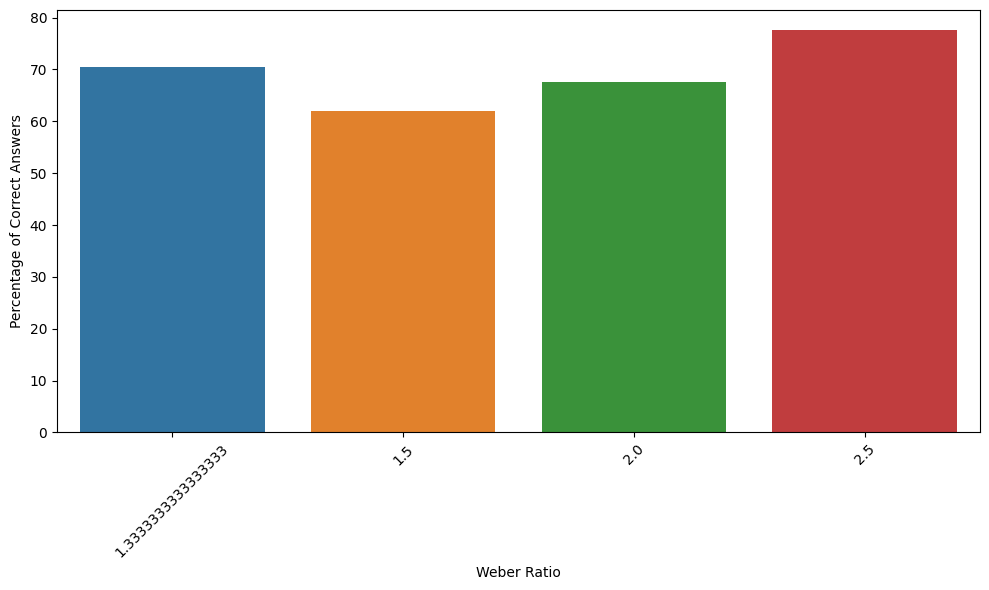

In [17]:
weber_plot = plot_weber_fraction(validation_results)

# Log validation metrics to wandb
if wandb_:
    log_validation_stats_to_wandb(running_loss, total_correct, total, validation_results, weber_plot)
    wandb.finish()

In [9]:
from pytorch_model_summary import summary

print(summary(DecodingImagesCNN(), torch.zeros((1, 34, 31, 31)), show_input=True))

---------------------------------------------------------------------------
          Layer (type)         Input Shape         Param #     Tr. Param #
              Conv2d-1     [1, 34, 31, 31]           4,912           4,912
         BatchNorm2d-2     [1, 16, 31, 31]              32              32
             Dropout-3     [1, 16, 15, 15]               0               0
              Conv2d-4     [1, 16, 15, 15]           4,640           4,640
         BatchNorm2d-5     [1, 32, 15, 15]              64              64
              Conv2d-6       [1, 32, 7, 7]          18,496          18,496
         BatchNorm2d-7       [1, 64, 7, 7]             128             128
   AdaptiveAvgPool2d-8       [1, 64, 3, 3]               0               0
              Linear-9             [1, 64]              65              65
Total params: 28,337
Trainable params: 28,337
Non-trainable params: 0
---------------------------------------------------------------------------
